In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr, spearmanr
import statsmodels.api as sm

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Data Preparation

## Data Imports

### Flow Data

In [3]:
flow_predictions = pd.read_csv('../results/yt_analysis/results.csv')
flow_predictions['VID'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
flow_predictions['FRAME'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-4]))
flow_predictions['FLOW_C'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-2]))
flow_predictions.drop(columns=['FILE'], inplace=True)
flow_predictions.loc[flow_predictions['PROB'] >= 0.5, 'FLOW_P_C'] = int(1)
flow_predictions.loc[flow_predictions['PROB'] < 0.5, 'FLOW_P_C'] = int(0)
flow_predictions.rename(columns={'PROB':'FLOW_P'}, inplace=True)
flow_predictions.head(5)

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C
0,0.652541,11,7258,1,1.0
1,0.518073,13,574,0,1.0
2,0.592700,12,6192,0,1.0
3,0.474445,42,7136,0,0.0
4,0.345597,19,1075,0,0.0


### Fer Private


In [4]:
fer_private = pd.read_csv('../results/yt_analysis/FER_results_private.csv').drop(columns=['FLOW'])
fer_private[['PRIVATE_ANGRY_P', 'PRIVATE_FEAR_P', 'PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']] = \
    fer_private['EMO_P'].str.strip('[').str.strip(']').str.split(' ', expand=True).loc[:,0:5].apply(pd.to_numeric, errors='coerce')
fer_private['VID'] = fer_private['VID'].astype('int')
fer_private['FRAME'] = fer_private['FRAME'].astype('int')
fer_private.rename(columns={'EMO_C':'EMO_PRIVATE'}, inplace=True)
emo_private_dummies= pd.get_dummies(fer_private['EMO_PRIVATE'],drop_first=False, prefix='PRIVATE').add_suffix('_C')
fer_private = pd.concat([fer_private, emo_private_dummies],axis=1 )
fer_private.drop(columns=['EMO_P'], inplace=True)
fer_private.head(5)

,VID,FRAME,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
0,35,4828,neutral,1.060863e-02,5.868053e-04,0.000093,0.697780,0.250793,4.013845e-02,0,0,0,1,0,0
1,10,1000,sad,1.218641e-07,3.595444e-07,0.000002,0.001313,0.998684,4.138556e-07,0,0,0,0,1,0
2,10,1001,sad,7.561166e-07,5.696014e-06,0.000015,0.006154,0.993822,2.700594e-06,0,0,0,0,1,0
3,10,1002,sad,1.872831e-06,9.105769e-06,0.000019,0.051558,0.948405,6.697891e-06,0,0,0,0,1,0
4,10,1003,sad,1.565203e-07,4.356439e-07,0.000002,0.003426,0.996571,7.726713e-07,0,0,0,0,1,0


## Merging

In [5]:
full_df = flow_predictions.merge(fer_private, on=['VID','FRAME'])
full_df.fillna(0, inplace=True)
full_df.head(5)

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
0,0.652541,11,7258,1,1.0,neutral,0.000181,0.000250,0.000006,0.993061,0.000229,0.006274,0,0,0,1,0,0
1,0.518073,13,574,0,1.0,sad,0.000427,0.000091,0.000173,0.024299,0.974595,0.000416,0,0,0,0,1,0
2,0.592700,12,6192,0,1.0,neutral,0.001214,0.000314,0.000592,0.927147,0.069780,0.000953,0,0,0,1,0,0
3,0.474445,42,7136,0,0.0,sad,0.000025,0.000007,0.000897,0.274898,0.722561,0.001612,0,0,0,0,1,0
4,0.345597,19,1075,0,0.0,neutral,0.001108,0.000022,0.000221,0.993751,0.004663,0.000236,0,0,0,1,0,0


# Visual Analysis

## Flow as Class

### Predicted Class

<AxesSubplot:xlabel='EMO_PRIVATE', ylabel='FLOW_P'>

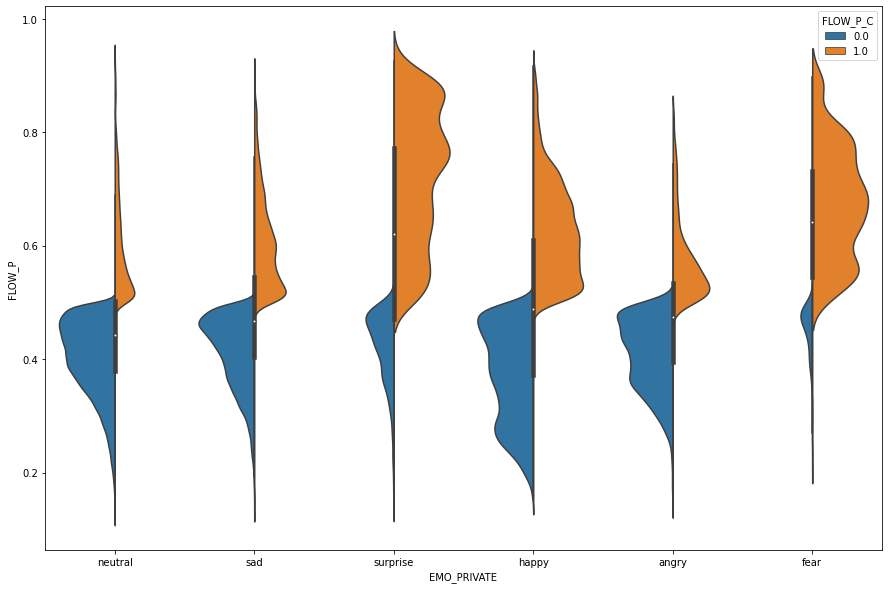

In [6]:
plt.figure(figsize=(15,10))
sns.violinplot(data=full_df[['FLOW_P_C','FLOW_P','EMO_PRIVATE']], x='EMO_PRIVATE', y='FLOW_P', hue='FLOW_P_C', split=True, scale="count")

### Labeled Class

<AxesSubplot:xlabel='EMO_PRIVATE', ylabel='FLOW_P'>

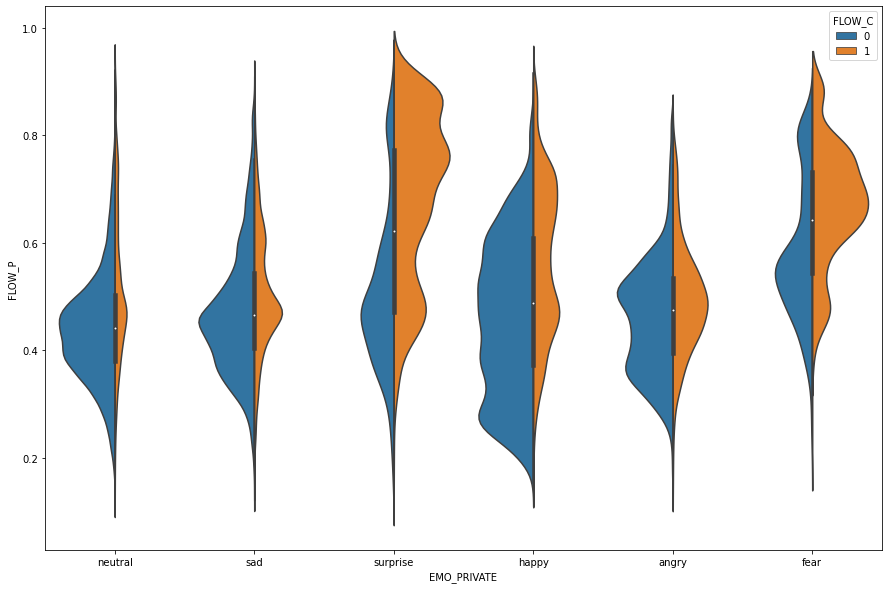

In [7]:
plt.figure(figsize=(15,10))
sns.violinplot(data=full_df[['FLOW_C','FLOW_P','EMO_PRIVATE']], x='EMO_PRIVATE', y='FLOW_P', hue='FLOW_C', split=True, scale="count")


# Correlation Analysis

## Flow Probabilites

In [8]:
print('SURPRISE and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_SURPRISE_P']))
print('FEAR and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_FEAR_P']))
print('HAPPY and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_HAPPY_P']))
print('ANGRY and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_ANGRY_P']))
print('SAD and FLOW', spearmanr(full_df['FLOW_P'], full_df['PRIVATE_SAD_P']))
print('NEUTRAL and FLOW', spearmanr(full_df['FLOW_P'], full_df['PRIVATE_NEUTRAL_P']))

SURPRISE and FLOW: (0.1850039841467224, 0.0)
FEAR and FLOW: (0.13149918314240716, 0.0)
HAPPY and FLOW: (0.07196564485415087, 1.2200599531821756e-270)
ANGRY and FLOW: (0.015721178925043922, 1.7351449397754202e-14)
SAD and FLOW (0.07600077874720507, 1.1108136764928337e-301)
NEUTRAL and FLOW (-0.17447620316643744, 0.0)


## Flow Predicted Class

In [9]:
print('SURPRISE and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_SURPRISE_P']))
print('FEAR and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_FEAR_P']))
print('HAPPY and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_HAPPY_P']))
print('ANGRY and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_ANGRY_P']))
print('SAD and FLOW', spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_SAD_P']))
print('NEUTRAL and FLOW', spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_NEUTRAL_P']))

SURPRISE and FLOW: SpearmanrResult(correlation=0.18229936913460543, pvalue=0.0)
FEAR and FLOW: SpearmanrResult(correlation=0.22430186552698117, pvalue=0.0)
HAPPY and FLOW: SpearmanrResult(correlation=0.1499185064405539, pvalue=0.0)
ANGRY and FLOW: SpearmanrResult(correlation=0.13271767411120108, pvalue=0.0)
SAD and FLOW SpearmanrResult(correlation=0.07022826684815352, pvalue=8.42032914005076e-258)
NEUTRAL and FLOW SpearmanrResult(correlation=-0.18940200846821373, pvalue=0.0)


## Flow Class

In [10]:
print('SURPRISE and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_SURPRISE_P']))
print('FEAR and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_FEAR_P']))
print('HAPPY and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_HAPPY_P']))
print('ANGRY and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_ANGRY_P']))
print('SAD and FLOW', spearmanr(full_df['FLOW_C'], full_df['PRIVATE_SAD_P']))
print('NEUTRAL and FLOW', spearmanr(full_df['FLOW_C'], full_df['PRIVATE_NEUTRAL_P']))

SURPRISE and FLOW: SpearmanrResult(correlation=0.11789768175468805, pvalue=0.0)
FEAR and FLOW: SpearmanrResult(correlation=0.20503212292493156, pvalue=0.0)
HAPPY and FLOW: SpearmanrResult(correlation=0.13168113755159727, pvalue=0.0)
ANGRY and FLOW: SpearmanrResult(correlation=0.11722728560405987, pvalue=0.0)
SAD and FLOW SpearmanrResult(correlation=0.15072192047178945, pvalue=0.0)
NEUTRAL and FLOW SpearmanrResult(correlation=-0.22813392971313037, pvalue=0.0)


# Regression Analysis

In [11]:
X = full_df[['PRIVATE_ANGRY_P',  'PRIVATE_FEAR_P','PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']]
y = full_df['FLOW_P']

model = sm.GLS(y,X, familiy=sm.families.Binomial())
model = model.fit(cov_type='HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 FLOW_P   R-squared (uncentered):                   0.940
Model:                            GLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                          6.496e+05
Date:                Thu, 05 Nov 2020   Prob (F-statistic):                        0.00
Time:                        09:19:14   Log-Likelihood:                      1.7115e+05
No. Observations:              237927   AIC:                                 -3.423e+05
Df Residuals:                  237921   BIC:                                 -3.422e+05
Df Model:                           6                                                  
Covariance Type:                  HC3                                                  
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
PRIVATE_ANGRY_P        0.4758      0.002    249.964      0.000       0.472       0.479
PRIVATE_FEAR_P         0.7198      0.005    140.517      0.000       0.710       0.730
PRIVATE_HAPPY_P        0.4933      0.001    420.602      0.000       0.491       0.496
PRIVATE_NEUTRAL_P      0.4465      0.000   1543.522      0.000       0.446       0.447
PRIVATE_SAD_P          0.4842      0.001    856.144      0.000       0.483       0.485
PRIVATE_SURPRISE_P     0.6918      0.004    177.791      0.000       0.684       0.699
==============================================================================
Omnibus:                    14715.031   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19778.963
Skew:                           0.568   Prob(JB):                         0.00
Kurtosis:                       3.840   Cond. No.                         14.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

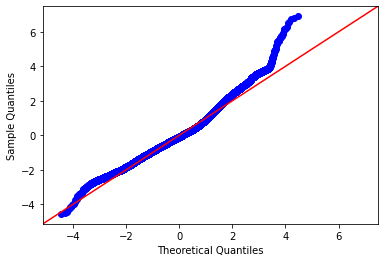

In [12]:
fig=sm.qqplot(model.resid, line='45',fit=True)

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

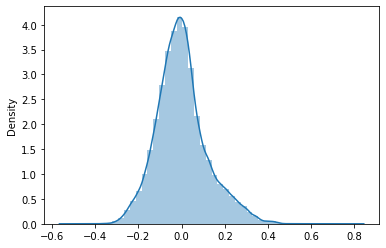

In [13]:
sns.distplot(model.resid)

In [14]:
full_df.describe()

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
count,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,2.379270e+05,2.379270e+05,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000
mean,0.464687,31.779638,4244.522782,0.230436,0.308965,1.891606e-02,5.659965e-03,0.082938,0.656657,0.217929,0.016838,0.016930,0.004972,0.082660,0.670029,0.212843,0.012567
std,0.121232,16.512120,3234.971234,0.421113,0.462067,1.112711e-01,5.535440e-02,0.254819,0.417220,0.356952,0.094562,0.129008,0.070338,0.275368,0.470203,0.409318,0.111396
min,0.120255,1.000000,0.000000,0.000000,0.000000,1.033659e-11,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384722,18.000000,1633.500000,0.000000,0.000000,1.425536e-06,2.180123e-07,0.000003,0.140239,0.000164,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.452344,30.000000,3554.000000,0.000000,0.000000,1.442285e-05,2.624158e-06,0.000027,0.943640,0.006139,0.000040,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.522414,46.000000,6179.000000,0.000000,1.000000,1.916726e-04,3.847822e-05,0.000622,0.998485,0.288253,0.000500,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.932560,60.000000,19516.000000,1.000000,1.000000,1.000000e+00,9.998215e-01,1.000000,1.000000,1.000000,0.999987,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


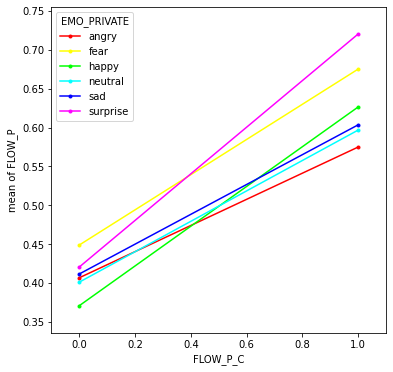

In [15]:
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(x=full_df['FLOW_P_C'], trace=full_df['EMO_PRIVATE'], response=full_df['FLOW_P'],
                        ax=ax)

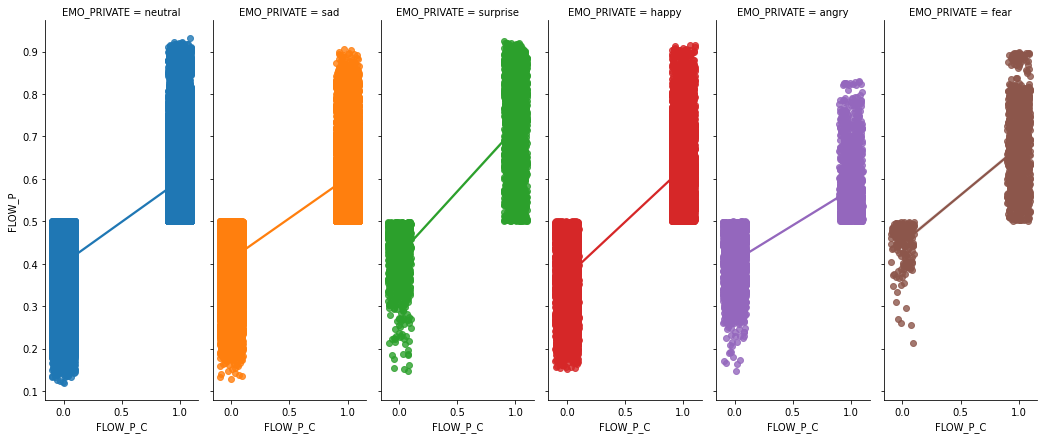

In [16]:
g = sns.lmplot(x="FLOW_P_C", y="FLOW_P", hue="EMO_PRIVATE", col="EMO_PRIVATE",
               data=full_df, height=6, aspect=.4, x_jitter=.1)
